# Análise de Sentimentos

#### Victor Marcius Magalhães Pinto

Este exercício diz respeito ao tratamento de texto e seu uso em tarefas de classificação. Para este exercício, utilizaremos um connjunto de dados do *kaggle*, oriundos de site de *e-commerce*, que, entre outros dados, contém um dataset com mensagens de avaliação de produtos e sua pontuação atribuída, por consumidores, em um site [1]. 

Para a tarefade classificação, foi realizado um pré-tratamento dos mesmos, isolando apenas a coluna de mensagens (`message`) e a coluna de `scores` como target. As avaliações vão de 1 a 5, e para transformar em um problema de classificação binária, uma agregação dos mesmos foi feita, da forma:

- 1 a 3 são classificados como `bad reviews` (classe 0)
- 4 e 5 são classificados como `good reviews` (classe 1)

Além disso, amostras com o review faltante foram substituídos por uma string "none". O dataset resultante foi salvo com o nome `review_message.csv`.

Primeiramente importamos as bibliotecas utilizadas para o projeto. Algumas funções foram encapsuladas, e importadas nesse notebook. Ao final serão mostradas.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
from collections import Counter
from os.path import join
import warnings

from sklearn.decomposition import PCA
import click
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.optim import Adam

from src.model import MLP
from src.normalizer import Normalizer
from src.pipelines import Pipeline
from src.text_tokenize import TextTokenizer

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Para realizar a *tokenização* das frases, era necessário avaliar um dataset diferente do utilizado para predição, para evitar *leaking* de dados. Conceitualmente, isso faz sentido, onde realizamos todo o processo de extração de características em um dataset disponível, incluindo a *tokenização*, e aí sim aplicamos todas as transformações nos dados reais, sem que os valores destes tenham sido usados em qualquer parte do processo. Por isso, do conjuntos de dados tratado, vamos separar $25\%$ para ser utilizados como caso de teste depois, e realizar o processo de extração de características sobre os $75\%$ restantes.

Dos dados tratados, devido ao processode salvamento, ainda é possível que alguns dados "none" tenham sido salvos como um valor `null` numérico do `numpy`, por exemplo. Por isso primeiramente vamos tratar esses dados novamente, inserindo "none" como valor. As amostras onde nenhum comentário foi colocado, apenas a nota, podem ser uma fonte de ruído, uma vez que é impossível saber a opinião do consumidor a partir disso. Portanto, todas as amostras com o valor "none" atribuído serão eliminadas do conjunto de dados. O conjunto de dados é desbalanceado, portanto para realizar a binarização da saída do modelo mais tarde, vamos salvar a proporção entre as classes. 

A saída do modelo é uma função sigmoidal, e para transformá-la em uma saída binária, um threshold de 0.5 pode ser aplicado. Porém como o conjunto de dados é  desbalanceado, experimentalmente, aplicar um threshold proporcional à probabilidade da classe desejada obteve um desempenho melhor de classificação.

In [5]:
LOAD_WORDMAP = True

try:
    df = pd.read_csv(join(".", 'data', 'processed', 'review_message.csv'))
except FileNotFoundError:
    df = pd.read_csv(join("..", 'data', 'processed', 'review_message.csv'))

click.echo(f'Data frame loaded with {df.shape[0]} rows.')

# Cleaning missing data
df["message"] = df["message"].apply(lambda d: "none" if type(d) == float else d)
click.echo(f"Number of float values {df[df.message.apply(type) == float].shape[0]}")
df = df[df['message'] != 'none']

# Splitting into train / test data
X = df.drop(['score'], axis=1)
y = df["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

#  Calculate the class ratio
class_ratio = y_train[y_train == 1].shape[0] / y_train.shape[0]

click.echo(f"Class balance ratio : {class_ratio:0.2f}% of data is class 1.")
click.echo(f'Train size {X_train.shape[0]} - Test size {X_test.shape[0]}')

Data frame loaded with 100000 rows.
Number of float values 0
Class balance ratio : 0.64% of data is class 1.
Train size 31239 - Test size 10414


Com isso pronto, o próximo passo é gerar tokens para as palavras registradas. Para isso, a estratégia utilizada foi criar um mapa de palavra $\to$ número, sendo este número atribuído com base na frequência de ocorrência da mesma, considerando todo o conjunto de dados de texto. Quanto mais frequente a palavra, maior o valor do token. 

Em cada frase, apeas os substativos, adjetivos, verbos e advérbios foram considerados, por serem mais significativos no sentimento escrito. O pacote python `spaCy` [2] foi utilizado para a análise semântica das palavras neste ponto. Um outro ajuste realizado foi transformar as palavras para seus *lemmas*, como conjugações no infitivo, por exemplo, para simplificar variações que na realidade não acrescentam muito pro sentido final, como por exemplo considerar "entrega", "entregaram", "entregam" como tokens diferentes, quando na realidade significam a mesma coisa.

In [6]:
click.echo('Generating word map')
tk = TextTokenizer(X_train, "message", use_gpu=True, n_tokens=200)

click.echo(f'Tokenizing datasets')

X_train['message'] = X_train['message'].apply(lambda d: [tk.get(w) for w in d.split()])
X_test['message'] = X_test['message'].apply(lambda d: [tk.get(w) for w in d.split()])

Generating word map
Using GPU for spacy.
9529 words mapped.
Tokenizing datasets


Com isso os dados passam a ser uma coluna composta de um vetor de números. Como limitamos a quantidade de tokens em 200, podemos ter apenas 200 opções diferentes. Isso significa que agora podemos ter um dataset com um número fixo de features para cada amostra, se considerarmos cada token como uma coluna. Isto nos possibilita colocar em uma mesma dimensão frases de tamanhos diferentes. 

Traduzindo então estes vetores em uma matriz esparsa, onde cada coluna armazena a quantidade de vezes que determinado token foi observado na frase, geramos um novo conjunto de dados

In [9]:
click.echo('Generating sparse features per token')

sparse_columns = [k for k in range(tk.n_tokens)]

new_dataset = []
with click.progressbar(X_train.iterrows(), length=X_train.shape[0], label="Generating sparse train dataset") as bar:
    for index, row in bar:
        new_dataset += [dict(Counter(row['message']))]

X_train = pd.DataFrame(new_dataset, columns=sparse_columns)

new_dataset = []
with click.progressbar(X_test.iterrows(), length=X_test.shape[0], label="Generating sparse test dataset") as bar:
    for index, row in bar:
        new_dataset += [dict(Counter(row['message']))]

X_test = pd.DataFrame(new_dataset, columns=sparse_columns)

del sparse_columns, new_dataset

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

Generating sparse features per token


Porém, uma matriz esparsa significa um desperdício no armazenamento de informações, uma vez que uma grande parte dos valores é zero. Para tanto, uma rotina de redução de dimensionalidade pode ser aplicada neste conjunto, e neste exercício escolhi PCA.

Primeiramente a rotina de PCA é aplicada de forma a obter a quantidade de features necessárias, em uma nova base, para explicar $95\%$ da variância dos datasets. Porém, para fins de plotagem, limitei a quantidade mínima de features a serem reduzidas a duas, caso o PCA indique que com apenas 1 feature podemos obter essa explicabilidade.

In [11]:
click.echo(f"Applying PCA")

pca = PCA(n_components=0.95)

pca.fit(X_train)
n_components = max(2, pca.n_components_)
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)

click.echo(f'Number of components obtained through PCA for 95% variance: {n_components}')

X_test = pca.transform(X_test)

Applying PCA
Number of components obtained through PCA for 95% variance: 2


Em seguida, como será utilizada uma rede neural, é uma boa prática normalizar os dados de entrada ao longo das features. Isto ajuda tanto na velocidade de convergência de algoritmos de otimização, ao minimizarem funções de erro para a correção dos pesos, quanto para evitar *gradient vainishing* e *gradient exploding* quando a correção dos pesos tende a zero ou infinito, no *backpropagation*, devido ao gradiente. Normalizar os dados ainda ajuda a evitar sobreajuste da rede, na medida em que todos os pesos passam a ter a mesma importância, pelo fato de as features estaram na mesma ordem.

O algoritmo PCA do pacote *scikit-learn* já centraliza os dados em torno do zero antes de fazer os cálculos (visto que este é um dos requisitos para se aplicar PCA), mas irei rodar a rotina toda de normalização como se este fato não ocorresse. A normalização aplicada é padrão, visto ser a mais comum:

$$
    x' = \frac{x - \mu}{\sigma}
$$

Como não encontrei inicialmente um pacote que realizasse a normalização ao longo das features apenas, e que salvasse os parâmetros $\mu$ e $\sigma$ obtidos em um conjunto de treinamento, para serem utilizados mais tarde em um conjunto distinto, implementei uma classe para tal, que pode ser vista no apêndice deste exercício.

In [12]:
click.echo(f"Normalizing data for neural network.")

normalizer = Normalizer()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

Normalizing data for neural network.


Com os dados prontos, o modelo pôde ser construído. Utilizei o pacote `pytorch` para construir a rede neural, e poder executá-la em GPU. O modelo encontra-se em anexo. Para rodar a rotina de treinamento também, constuí uma classe de `pipeline`, que agregasse toda a rotina necessária para treinar um modelo neste pacote.

O modelo utilizado foi uma MLP com uma camada escondida de 50 neurônios, e de ativação ReLU. A camada de saída consiste de um neurônio com a função sigmoidal. Para a avaliação da performance com dados binários, o threshold calculado anteriormente foi utilizado. A função de perda sendo otimizada é de entropia cruzada binária, e os pesos foram corrigidos utilizando o otimizador **Adam**.

Durante a execução do pipeline de treino, $5\%$ da amostra foi utilizada como validação, para fins de acompanhamento das métricas de desempenho do modelo ao longo do processo. Isso significa que $95%$ dos dados foram utilizados para treinamento, e o restante ficou de fora para fins de métricas.

In [ ]:
click.echo(f"Building model")

device = torch.device("cuda")

model = MLP(n_components)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_function = nn.BCELoss()

pipeline = Pipeline(epochs=500, validation_size=0.05)

click.echo(f"Initiating training pipeline")

X_train_torch = torch.from_numpy(X_train).float().to(device)
y_train_torch = torch.from_numpy(y_train.to_numpy()).float().to(device)

X_test_torch = torch.from_numpy(X_test).float().to(device)
y_test_torch = torch.from_numpy(y_test.to_numpy()).float().to(device)

pipeline.train(
    model=model,
    optimizer=optimizer,
    loss_function=loss_function,
    x_train=X_train_torch,
    y_train=y_train_torch
)

As perdas calculadas durante o treinamento, bem como as métricas no conjunto de validação podem ser vistas nos gráficos à seguir.

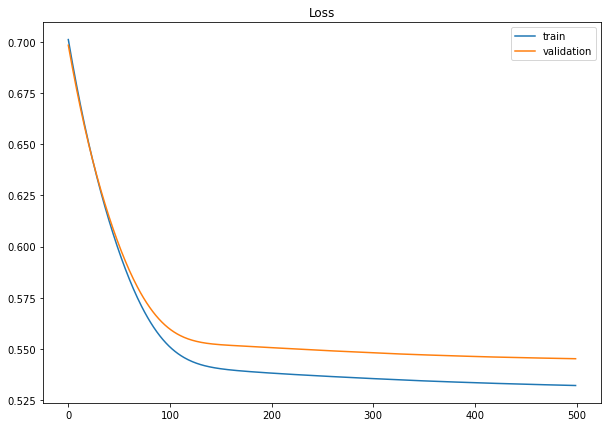

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(pipeline.train_losses, label='train')
ax1.plot(pipeline.validation_losses, label='validation')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax1.set(title='Loss')
plt.show()

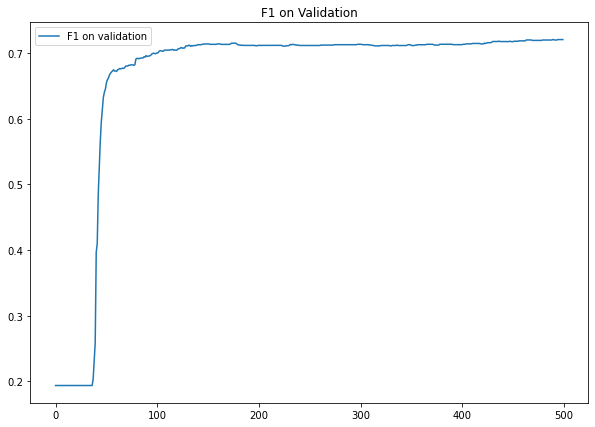

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(pipeline.f1_score_validation, label='F1 on validation')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax1.set(title='F1 on Validation')
plt.show()

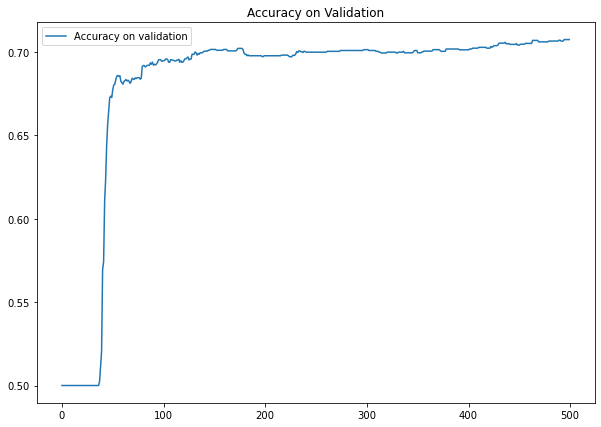

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(pipeline.accuracy_validation, label='Accuracy on validation')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax1.set(title='Accuracy on Validation')
plt.show()

E as amostras juntamente com a superfície de separação formada:

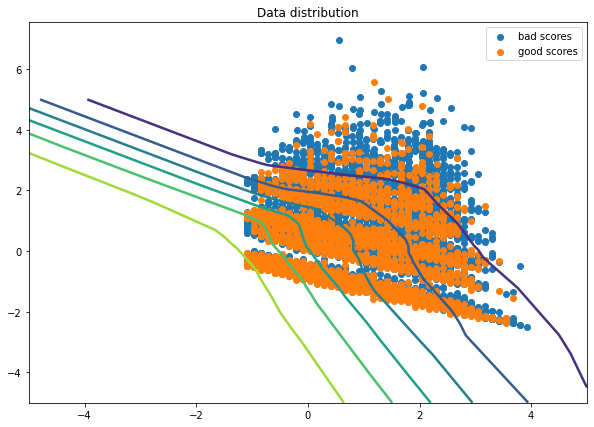

In [22]:
if n_components == 2:
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='bad scores')
    ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='good scores')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')
    ax1.set(title='Data distribution')

    x_lab = np.linspace(-5, 5, num=1000)
    y_lab = np.linspace(-5, 5, num=1000)
    x1, x2 = np.meshgrid(x_lab, y_lab)
    x_grid = np.transpose(np.vstack([x1.flatten(), x2.flatten()]))

    with torch.no_grad():
        x_grid_torch = torch.from_numpy(x_grid).float().to(device)
        pred = model(x_grid_torch)
        z = pred.squeeze().cpu().numpy()
    z = z.reshape([1000, 1000])
    ax1.contour(x1, x2, z, linewidths=(2.5,))

    plt.show()

    del pred

E, avaliando o modelo obtido sobre os dados separados anteriormente para teste, vemos os resultados à seguir:

In [23]:
with torch.no_grad():
    pred = model(X_test_torch)
    y_pred_bin = [1 if d > class_ratio else 0 for d in pred.squeeze().cpu().numpy()]

score = f1_score(y_test_torch.cpu().numpy(), y_pred_bin, average='weighted')
auc = roc_auc_score(y_test_torch.cpu().numpy(), y_pred_bin, average='weighted')
print(classification_report(y_test_torch.cpu().numpy(), y_pred_bin))


click.secho(f"F1 score on test data: {score} - auc: {auc}", fg='green')

              precision    recall  f1-score   support

         0.0       0.61      0.68      0.64      3741
         1.0       0.81      0.76      0.78      6673

    accuracy                           0.73     10414
   macro avg       0.71      0.72      0.71     10414
weighted avg       0.74      0.73      0.73     10414

F1 score on test data: 0.731369530397033 - auc: 0.7176471646242404


Como mencionado, se durante a binarização utilizasse 0.5 como threshold, a performance do modelo final seria pior para a classe com menor número de amostras:

In [24]:
with torch.no_grad():
    pred = model(X_test_torch)
    y_pred_bin = [1 if d > 0.5 else 0 for d in pred.squeeze().cpu().numpy()]

score = f1_score(y_test_torch.cpu().numpy(), y_pred_bin, average='weighted')
auc = roc_auc_score(y_test_torch.cpu().numpy(), y_pred_bin, average='weighted')
print(classification_report(y_test_torch.cpu().numpy(), y_pred_bin))


click.secho(f"F1 score on test data: {score} - auc: {auc}", fg='green')

              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60      3741
         1.0       0.77      0.88      0.82      6673

    accuracy                           0.75     10414
   macro avg       0.74      0.70      0.71     10414
weighted avg       0.74      0.75      0.74     10414

F1 score on test data: 0.7395508795523158 - auc: 0.6992122519692899


Podemos ver que apesar de haver uma melhora na precisão da classe 0, há uma queda na precisão da classe 1, e uma queda no recall da classe 0 também, que se reflete no cálculo do f1-score da mesma.

## Análise dos Resultados

A estratégia adotada para a extração de características de texto foi simples. Não foi levado em consideração a estrutura da frase, e o processo de conversão das palavras em tokens levou apenas em consideração a frequência das mesmas. A forma de classificar os textos dos comentários, criando tokens baseados no número de ocorrências de uma palavra no texto pode acabar criando uma relação entre palavras semanticamente diferentes, apenas por terem uma frequência parecida. Por exemplo, pode ser atribuído o token 29 e 30 às palavras `bom` e `quando` por terem uma frequência parecida de ocorrência, e com isso indicar para o classificador que ter essas duas palavras, ou ter somente uma das duas, pode ter uma classificação parecida. Mais do que isso, inserimos ruído nos dados. Por exemplo ter um token 29 pode significar uma classificação positiva na maioria das vezes, porém ter o token 30 não possui uma correlação significativa entre uma classificação positiva e sua ocorrência. Isso pode dificultar do classificador determinar uma borda de separação.

Esse tipo de problema na tokenização é comum quando lidamos com dados categóricos, onde inserir números pode acabar criando uma relação de importância, uma hierarquia que não existe de verdade. Por isso por vezes uma tokenização da forma `OneHot Encoding` é preferida, apesar de esparsa.

Como pode ser visto no gráfico do espaço bidimensional gerado, houve uma sobreposição das amostras na base resultante, sem um limite claro de um separador possível. Isso explica parte do desempenho da rede.

O modelo utilizado também não levava em conta particularidade que poderiam advir do tratamento de texto, como temporalidade, por exemplo. 

Apesar disso tudo, o modelo obteve um desempenho superior ao esperado para uma aplicação simples, onde, como pode ser visto pelo AUC, possui uma performance superior a um classificador aleatório. Isto demonstra que o processo de extração de características do texto, mesmo que simples, ainda é poderoso no tratamento deste tipo de problema.

Para uma melhor performance, o processo de *embedding* das palavras poderia levar em consideração a ocorrência delas no text, por exemplo, de forma a agrupar palavras que tem mais chances de ocorrerem juntas, ou que possam ter características parecidas dentre as amostras de frases observadas, como em treinamentos utilizando Word2Vec e dicionários.

O modelo utilizado também poderia levar em consideração a temporalidade das frases, como por exemplo a ordem em que as palavras ocorem, para que passe a analisar uma frase como uma série, por exemplo. A utilização de uma rede LSTM é uma alternativa viável.

## Referências



[1] Olist and André Sionek, “Brazilian E-Commerce Public Dataset by Olist.” Kaggle, doi: 10.34740/KAGGLE/DSV/195341.

[2] Honnibal, Matthew and Montani, Ines, spaCy 2: Natural language understanding with Bloom embeddings, convolutional neural networks and incremental parsing. 2017.

---

# Apêndice

## text_tokenizer.py

In [ ]:
import json
from collections import Counter
from os.path import join
from typing import List, AnyStr, Union, Dict

import click
import numpy as np
import pandas as pd
import spacy
import unidecode as ud
from sklearn.model_selection import train_test_split


class TextTokenizer:
    """
    Receives a document or a document dataset and creates a mapping of words to numerical tokens, based on occurrence.
    """

    def __init__(
            self,
            data: Union[pd.DataFrame, str] = None,
            column_name: str = None,
            n_tokens: int = 100,
            use_gpu: bool = False
    ):
        """
        Constructor method of the Tokenizer object.

        Parameters
        ----------
        data: Union[pd.DataFrame, str]
            The document or dataset to be analysed.
        column_name:
            If the document is a pandas data frame, this parameter  indicates the name of the column with the documents.
        n_tokens: int
            The number of valid words to create the mapping with.
        use_gpu: bool
            Allow GPU use for spaCy package.
        """

        if data is not None and data.all() is not None and not data.empty:

            self.map: Dict = {}
            self.n_tokens = n_tokens

            if use_gpu:
                click.secho("Using GPU for spacy.", fg='yellow')
                spacy.prefer_gpu()

            self.nlp = spacy.load("pt_core_news_sm")
            words = []
            if isinstance(data, pd.DataFrame):
                words = self._from_df(data, column_name)
            elif isinstance(data, str):
                words = self._from_string(data)
            else:
                raise ValueError(f"Not recognized type {type(data)}.")

            self.fit(words)

    def clean_string(self, data: str) -> List[AnyStr]:
        """
        Receives a string phrase and return a list of words from it, considering Nouns, Adverbs, Adjectives and Verbs.
        This method uses spaCy package to parse and identify words. For each word listed, it returns its lower case
        lemma, with accentuation removed (process called normalization of a string).

        Parameters
        ----------
        data: str
            The phrase to be parsed.

        Returns
        -------
        List[AnyStr]:
            List of the normalized lower case lemma for each word.
        """

        doc = self.nlp(data)
        clean_words = []
        for token in doc:
            if token.pos_ not in ["NOUN", "ADV", "ADJ", "VERB"]:
                continue
            clean_words.append(ud.unidecode(token.lemma_.lower()))

        return clean_words

    def _from_df(self, df: pd.DataFrame, column_name: str) -> List[AnyStr]:
        """
        Returns a list of words from a pandas DataFrame object.

        Parameters
        ----------
        df: pd.Dataframe
            Pandas data frame with the strings to be parsed.
        column_name: str
            Name of the column with the strings.

        Returns
        -------
        List[AnyStr]:
            List of words of the data frame, with repetitions.
        """

        words = []
        with click.progressbar(df.iterrows(), length=df.shape[0], label="Reading data frame") as bar:
            for index, row in bar:
                words += self.clean_string(row[column_name])

        return words

    def _from_string(self, s: AnyStr) -> List[AnyStr]:
        """
         Returns a list of words from a string object.

        Parameters
        ----------
        s: str
            The string to be parsed.

        Returns
        -------
        List[AnyStr]:
            List of words of the string, with repetitions.
        """

        return self.clean_string(s)

    def fit(self, words: List[AnyStr]) -> None:
        """
        With a list of words, create a mapping String to Integer considering number of occurrences as importance order.
        Words with higher occurrences receive a higher token value.

        Parameters
        ----------
        words: List[AnyStr]
            List of the words occurred.

        Returns
        -------
            None.
        """
        count_words = Counter(words)
        word_order = [k for k, v in sorted(count_words.items(), key=lambda item: item[1], reverse=True)]
        click.secho(f"{len(word_order)} words mapped.", fg='green')
        word_map = zip(word_order[0:self.n_tokens], np.arange(self.n_tokens-1, 0, -1))
        self.map = {word: int(value) for word, value in word_map}

    def get(self, word: str) -> int:
        """
        Do a search on the word map.

        Parameters
        ----------
        word: str
            Word to be mapped.

        Returns
        -------
        int:
            The respective token value, according th the mapping.
        """
        return self.map.get(ud.unidecode(word), 0)

    def load(self, map: Dict):
        self.map = map
        self.n_tokens = len(map)

        return self

---

## normalizer.py

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List, Union
import click


class Normalizer:

    def __init__(self):
        self.params: List[Dict] = []

    def fit(self, data: Union[np.ndarray, pd.DataFrame]):
        """
        Considering a base dataset, obtain the parameters used to calculate the normalization.
        
        Parameters
        ----------
        data: Union[np.ndarray, pd.DataFrame]
            Input data

        Returns
        -------
            None.
        """

        is_data_frame = isinstance(data, pd.DataFrame)

        for c in range(data.shape[1]):
            if is_data_frame:
                self.params.append({'mean': np.mean(data.iloc[:, c]), 'std': np.std(data.iloc[:, c])})
            else:
                self.params.append({'mean': np.mean(data[:, c]), 'std': np.std(data[:, c])})

    def transform(self, data: Union[np.ndarray, pd.DataFrame]):
        """
        Apply normalization calculation upon a data matrix.
        
        Parameters
        ----------
        data: Union[np.ndarray, pd.DataFrame]
            Input data to be transformec

        Returns
        -------
        Union[np.ndarray, pd.DataFrame]:
            Output transformed matrix. 
        """
        data_trans = data.copy()

        is_data_frame = isinstance(data, pd.DataFrame)

        with click.progressbar(length=np.prod(data.shape), label="Transforming data") as bar:
            for index in range(data.shape[0]):
                for c in range(data.shape[1]):
                    if is_data_frame:
                        data_trans.iloc[index, c] = (data.iloc[index, c] - self.params[c]["mean"]) / self.params[c]['std']
                    else:
                        data_trans[index, c] = (data[index, c] - self.params[c]["mean"]) / self.params[c]['std']
                    bar.update(1)

        return data_trans

    def fit_transform(self, data: Union[np.ndarray, pd.DataFrame]):
        """
        Fit data and transforms it.
        
        Parameters
        ----------
        data: Union[np.ndarray, pd.DataFrame]
            Input data matrix.

        Returns
        -------
        Union[np.ndarray, pd.DataFrame]:
            Output transformed matrix.
        """
        self.fit(data)

        return self.transform(data)

---

## model.py

In [ ]:
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, features: int):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(features, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layers(x)

        return x

---

## pipelines.py

In [ ]:
from typing import List, Union

import numpy as np
import torch
from sklearn.metrics import f1_score, balanced_accuracy_score
from torch.nn import Module
from torch.optim.optimizer import Optimizer


class Pipeline:

    def __init__(self, epochs: int = 100, splits: int = 5, validation_size: Union[int, float] = None):
        self.train_losses: List = []
        self.validation_losses: List = []
        self.f1_score_validation: List = []
        self.accuracy_validation: List = []
        self.val_size = validation_size
        self.epochs = epochs
        self.splits = splits

    def train(self, model: Module, optimizer: Optimizer, loss_function, x_train, y_train):

        if (self.val_size <= 1.0) and (self.val_size >= 0.0):
            num_val_samples = int(self.val_size * x_train.shape[0])
        elif self.val_size > 1:
            if self.val_size >= x_train.shape[0]:
                raise ValueError(f"Number of validation samples to be used ({self.val_size}) is equal or superior of training set sample count ({x_train.shape[0]}).")
            num_val_samples = int(self.val_size)
        else:
            num_val_samples = 0

        train_index, val_index = np.split(np.arange(x_train.shape[0]), [-num_val_samples])

        class_ratio = 0.5

        if num_val_samples > 0:
            print(f"Using {len(train_index)} samples to train and {len(val_index)} samples as validation set.")
            class_ratio = y_train[y_train == 1].shape[0] / y_train.shape[0]
            print(f"Class ratio: {class_ratio:0.2f} % of the samples within validation set belong to class 1.")

        for epoch in range(self.epochs):
            model.train()

            train_losses = []
            test_losses = []
            f1_scores = []
            accs = []

            val_log = ""

            optimizer.zero_grad()

            pred = model(x_train[train_index, :])
            loss = loss_function(pred.squeeze(), y_train[train_index])
            loss.backward()
            train_loss = loss.item()
            train_losses.append(train_loss)
            optimizer.step()

            if num_val_samples:
                model.eval()

                with torch.no_grad():
                    pred = model(x_train[val_index, :])
                    loss = loss_function(pred.squeeze(), y_train[val_index])
                    test_loss = loss.item()
                    test_losses.append(test_loss)
                    y_pred_bin = [1 if d > class_ratio else 0 for d in pred.squeeze().cpu().numpy()]
                    f1 = f1_score(y_train[val_index].cpu().numpy(), y_pred_bin, average='weighted')
                    acc = balanced_accuracy_score(y_train[val_index].cpu().numpy(), y_pred_bin)
                    f1_scores.append(f1)
                    accs.append(acc)

                avg_test_loss = np.mean(test_losses)
                avg_f1 = np.mean(f1_scores)
                avg_acc = np.mean(accs)
                self.validation_losses.append(avg_test_loss)
                self.f1_score_validation.append(avg_f1)
                self.accuracy_validation.append(avg_acc)

                val_log = f" - val loss: {avg_test_loss:.4f} - val f1 score: {avg_f1:0.4f} - val acc: {avg_acc:.4f}"

            avg_train_loss = np.mean(train_losses)
            self.train_losses.append(avg_train_loss)

            print(f"Epoch {epoch} of {self.epochs} - train loss: {avg_train_loss:.4f}{val_log}.")

        model.eval()
        print(f"Training finished.")

